In [3]:
#Loading useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import sys
import argparse

#General purpose AI packages
from sklearn.cross_validation import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error

#Keras packages
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import EarlyStopping

#XGBoost packages
import xgboost as xgb

/Users/cappe/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [4]:
DATAFILE = './data/data.csv'
TARGETFILE = './data/target.csv'
OUTDIR = './'

In [5]:
############## PREPARING DATA ##################################################
train = pd.read_table(DATAFILE,sep=',')
train = np.asarray(train)

target = pd.read_table(TARGETFILE,sep=',')
target = np.asarray(target)

train_size = 0.7 #70% a training set e 30% a validation set
X_tr, X_val, Y_tr, Y_val = train_test_split(train, target, train_size=train_size, random_state=0)
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

In [6]:
############## BUILDING NN  ####################################################
model = Sequential()
model.add(Dense(units=20, input_dim=12))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(units=50))
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error',optimizer='adam')

/Users/cappe/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/cappe/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [7]:
############## TRAINING NN  ####################################################
n_epochs = 300
n_batch = 32
history = model.fit(X_tr, Y_tr, validation_data = (X_val, Y_val),  epochs = n_epochs, batch_size = n_batch)

Train on 1607 samples, validate on 689 samples
Epoch 1/300
1607/1607 [==============================] - 0s - loss: 9476.5743 - val_loss: 9390.5407
Epoch 2/300
1607/1607 [==============================] - 0s - loss: 9392.2526 - val_loss: 9310.7305
Epoch 3/300
1607/1607 [==============================] - 0s - loss: 9286.1559 - val_loss: 9190.2260

In [8]:
############## PREPARING AND TRAINING XGB ######################################
model_trunc = Sequential()
model_trunc.add(Dense(units=20, input_dim=12,weights=model.layers[0].get_weights()))
model_trunc.add(Activation('relu'))
model_trunc.add(Dropout(0.1))
model_trunc.add(Dense(units=50,weights=model.layers[3].get_weights()))
model_trunc.add(Activation('sigmoid'))

act_tr = model_trunc.predict(X_tr)
act_val = model_trunc.predict(X_val)

/Users/cappe/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [9]:
params = {'booster': 'gblinear',
'max_depth': 10,
'min_child_weight':10,
'learning_rate':0.05,
'subsample':0.5,
'colsample_bytree':0.6,
'obj':'reg:logistic',
'n_estimators':1000,
'eta':0.3}
booster = xgb.train(params,xgb.DMatrix(act_tr,Y_tr))


 Score NN:  1446.44605509

 Score Booster:  1432.75864546


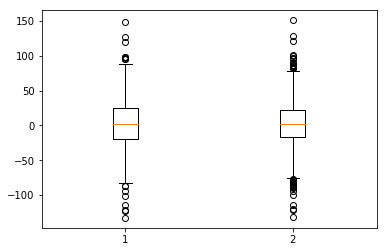

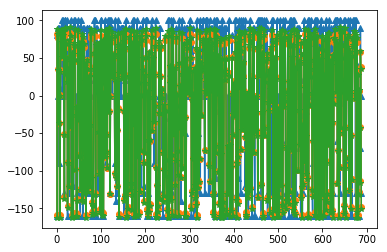

In [10]:
############## EVALUATING RESULTS  #############################################
Y_val = np.squeeze(Y_val)
Y_NN = np.squeeze(model.predict(X_val))
Y_BOO = booster.predict(xgb.DMatrix(act_val))

#MSE of the two methods
print('\n Score NN: ',mean_squared_error(Y_NN,Y_val))
print('\n Score Booster: ',mean_squared_error(Y_BOO,Y_val))

#Boxplot of the difference between actual values and estimates
data_to_plot = [Y_val-Y_NN,Y_val-Y_BOO]
plt.boxplot(data_to_plot)
plt.show()

#Plot of the actual values and estimates
plt.plot(Y_val, marker='^')
plt.plot(Y_NN, marker='o')
plt.plot(Y_BOO, marker = '*')
plt.show()